In [2]:
# Basics
import numpy as np
import os 
import pandas as pd
import math

# Image Loading
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
%matplotlib inline

# Evaluation
from sklearn import metrics
from skimage.measure import compare_mse
from skimage.metrics import structural_similarity as ssim
from skimage.external import tifffile
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer

# Data preprocessing
from sklearn.preprocessing import normalize, StandardScaler

# Dimensionality Reduction
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap                   # 1) T-SNE
from sklearn.decomposition import PCA               # 2) PCA

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model


In [3]:
## Data loading, and standardizing

trainData = "../Data/Kather_all" # 1.5k images //  96 x 96 x 3

new_train = []
image_names = []

# Test on 1000 images
for filename in os.listdir(trainData):
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(trainData, filename)) 
        new_train.append(np.asarray( image, dtype="uint8" ))
        image_names.append(filename)

meanMatrix = np.asarray(new_train)
X = meanMatrix.reshape((len(new_train),-1))
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [3]:
def ClusterAndPlot(n_clusters, D):
    Labels = []
    
    print(D.shape)
    HC = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='complete').fit(D)
    print('HC Silhouette Score  {} '.format(metrics.silhouette_score(D, HC.labels_)))

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(D)
    print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(D, kmeans.labels_)))

#     gmm = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(D)
#     gmmlabels_ = gmm.predict(D)
#     print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(D, gmmlabels_)))
    
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))
    axs[0, 0].scatter(D[:, 0], D[:, 1], cmap='viridis')
    axs[0, 0].set_title('Normal')

#     axs[0, 1].scatter(D[:, 0], D[:, 1], c=gmmlabels_, cmap='viridis')
#     axs[0, 1].set_title('GMM')

    axs[1, 0].scatter(D[:, 0], D[:, 1], c=kmeans.labels_, cmap='viridis')
    axs[1, 0].set_title('K-Means')

    axs[1, 1].scatter(D[:, 0], D[:, 1], c=HC.labels_, cmap='viridis')
    axs[1, 1].set_title('HC')
    plt.show()
    
    Labels.append(HC.labels_)
    Labels.append(kmeans.labels_)
#     Labels.append(gmmlabels_)
    return Labels


In [4]:
GMMparameters = {'n_components': range(2, 8), 'covariance_type': ['full', 'tied', 'diag', 'spherical']}
# KMeansparameters = {'n_clusters' : range(2, 8)}
Agglomerativeparameters = {'n_clusters' : range(2, 8), affinity : ['euclidean', 'manhatten'], linkage:['ward'] }
# silhouette_scorer = make_scorer(silhouette_score)
# clusterer = GridSearchCV(gm, parameters, scoring=silhouette_scorer)
# clusterer.fit(data)

def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
#     cluster_labels = estimator.predict(X).labels_
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

cv = [(slice(None), slice(None))]
ca = GaussianMixture()
# ca = AgglomerativeClustering()
# ca = KMeans()
gs = GridSearchCV(estimator=ca, 
                  param_grid=GMMparameters, 
                  scoring=cv_silhouette_scorer, 
                  cv=cv, 
                  n_jobs=-1)
gs.fit(X)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
sorted(clf.cv_results_.keys())

In [ ]:
def pltPathologyClusters(labels):
    clusterimgDir = "../Data/clusters_journal.PNG"
    image = Image.open(clusterimgDir) 
    plt.figure(figsize = (85,12))
    plt.imshow(image)
    plt.axis('off')
    
    sub_directories = [str(cluster) for cluster in set(labels)]
    displayImages = []
    mseList = []
    valMse = []
    
    for cluster in sub_directories:
        direct = trainData + '/{}'.format(cluster)
        index = np.random.randint(9,len(os.listdir(direct))-9)
        clusterList = []
        for file in os.listdir(direct)[index:index+9]: # random sample of 9 images
            if file.endswith('.tif'):
                #image = Image.open(os.path.join(trainData, file)) 
                image = tifffile.imread(os.path.join(trainData, file))
                clusterList.append(image)
                displayImages.append(image)
        mseList.append(clusterList)
        
#         print(mseList)
#         print("Size of cluster {} is {}".format(str(cluster),len(os.listdir(direct))))
#         print("Taking images with the indices {} to {}\n".format(index, index+9))
    for clusterRow in mseList:
        Sum = 0
        for i in range(0,7,2):
            val = compare_mse(clusterRow[i], clusterRow[i+1])
            Sum += val
        valMse.append(math.ceil(Sum / 4))
            
    
    fig = plt.figure(figsize=(14, 14))
    
    columns = 9
    rows = len(sub_directories)
    print(len(displayImages))
    print(columns*rows+1)
    for i in range(1, columns*rows+1):
        img = displayImages[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
#     plt.show()
    
    return valMse


81
82


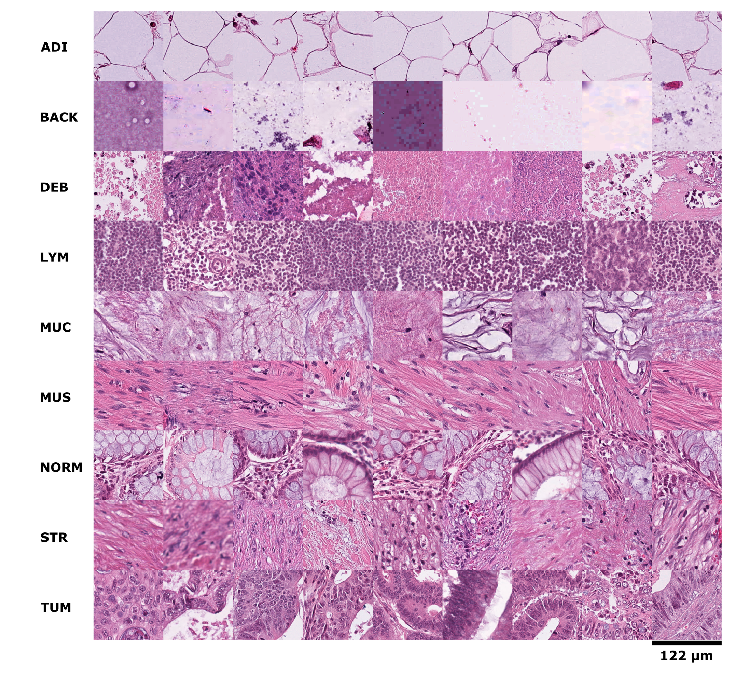

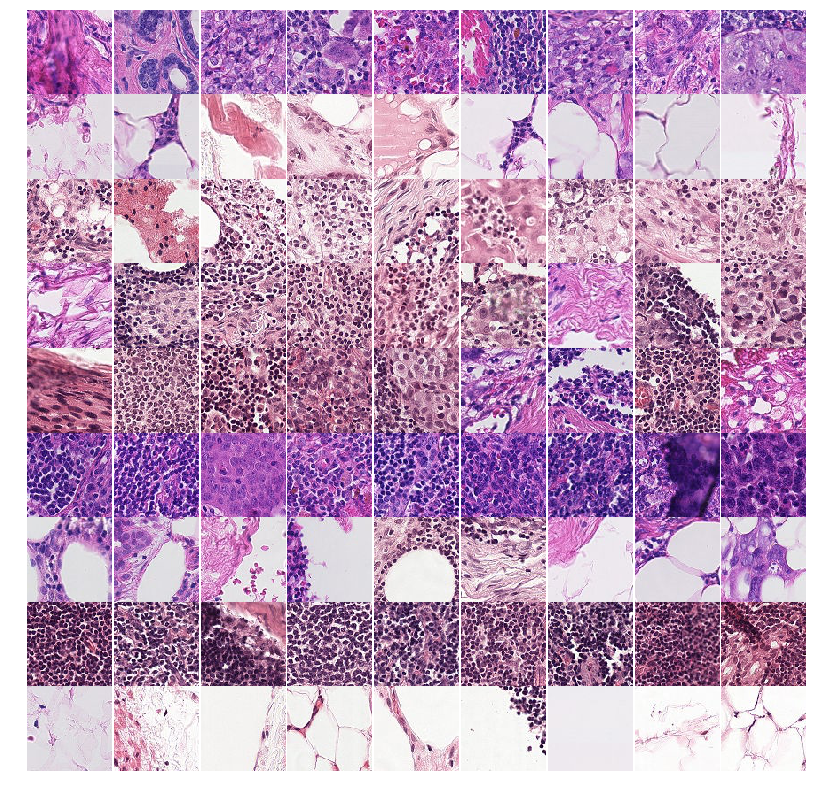

In [226]:
valMse = pltPathologyClusters(Labels[1])

In [227]:
valMse

[4217, 2718, 5574, 7372, 7105, 4697, 3991, 7804, 2158]

In [166]:
n_images = X.shape[0]
X.shape

(1575, 576)

In [138]:
meanMatrix.shape

(1575, 96, 96, 3)

(1575, 1152)
(1575, 2)


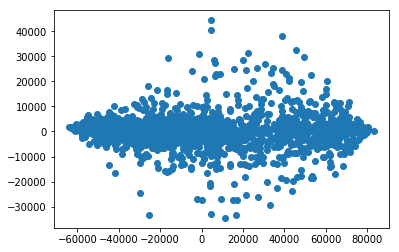

In [181]:
# embedding = LocallyLinearEmbedding(n_components=2)
# embedding = Isomap(n_components=2)
embedding = PCA(n_components=2)
# embedding = TSNE(n_components=2)
print(X.shape)
X_transformed = embedding.fit_transform(X)
print(X_transformed.shape)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap='viridis');

In [171]:
# autoencoder = load_model('Autoencoders/SavedModels/fulldata_checkpoint_epochs10000_batch32_adam.h5') # 6 x 6 x 16
autoencoder = load_model('Autoencoders/SavedModels/autoencoder_train_epochs100_batch32_best.h5') # 6 x 6 x 32
# autoencoder = load_model('Autoencoders/SavedModels/Regrcheckpoint_epochs30_batch128_adam.h5') # Regression with 32
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 96, 96, 16)        448       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 96, 96, 32)        4640      
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 48, 48, 64)        1849

In [36]:
trainData10k = "../Data/train" # 10k images //  96 x 96 x 3

train_10k = []
image_names_10k = []

# Test on 1000 images
for filename in os.listdir(trainData10k):
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(trainData10k, filename)) 
        train_10k.append(np.asarray( image, dtype="uint8" ))
        image_names_10k.append(filename)

meanMatrix_10k = np.asarray(train_10k)

# Evaluate regression
csvFilePath = "../Data/regrData/train_labels.csv"
df = pd.read_csv(csvFilePath)
testlabels = []

for image in image_names_10k:
    label_index = df[df["id"] == image.split(".")[0]].index[0]
    testlabels.append(df["label"][label_index])
    


TypeError: evaluateRegression() takes 0 positional arguments but 1 was given

In [38]:
evaluateRegression(meanMatrix_10k)

              precision    recall  f1-score   support

           0       0.60      0.24      0.34      5996
           1       0.40      0.75      0.52      4003

    accuracy                           0.45      9999
   macro avg       0.50      0.50      0.43      9999
weighted avg       0.52      0.45      0.42      9999



In [8]:
def evaluateRegression(imagesMatrix):
    labels_pred = autoencoder.predict(imagesMatrix)[1]
    for i in range(len(labels_pred)):
        if labels_pred[i] < 0.5:
            labels_pred[i] = 0
        else:
            labels_pred[i] = 1

    evaluation = metrics.classification_report(testlabels, labels_pred)
    print(evaluation)

In [9]:
# Evaluate regression
csvFilePath = "../Data/regrData/train_labels.csv"
df = pd.read_csv(csvFilePath)
testlabels = []

for image in image_names:
    label_index = df[df["id"] == image.split(".")[0]].index[0]
    testlabels.append(df["label"][label_index])
    



In [23]:
evaluateRegression(meanMatrix)

              precision    recall  f1-score   support

           0       0.62      0.26      0.36       958
           1       0.40      0.75      0.52       617

    accuracy                           0.45      1575
   macro avg       0.51      0.51      0.44      1575
weighted avg       0.53      0.45      0.42      1575



(1575, 6, 6, 32)
(1575, 1152)


Text(0.5, 1.0, 'Normal Reshaped')

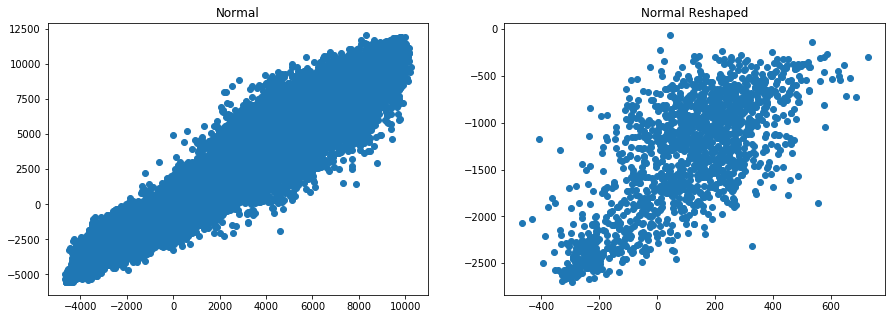

In [173]:
# layer_name = 'conv2d_7' # 6 x 6 x 16
layer_name = 'conv2d_30' # 6 x 6 x 32

intermediate_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

X = intermediate_layer_model.predict(meanMatrix)
print(X.shape)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(X[:, 0], X[:, 1], cmap='viridis')
axs[0].set_title('Normal')

X = X.reshape((n_images, -1))
print(X.shape)
axs[1].scatter(X[:, 0], X[:, 1], cmap='viridis')
axs[1].set_title('Normal Reshaped')

(1575, 1152)
HC Silhouette Score  0.16720405220985413 
kmeans Silhouette Score  0.193185493350029 


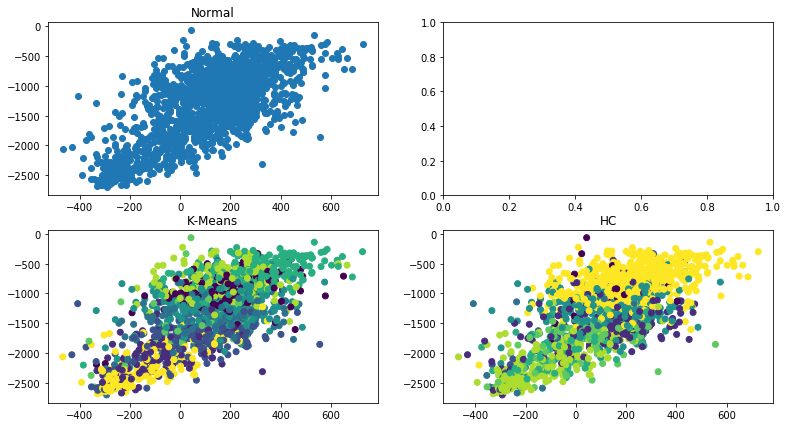

In [203]:
Labels = ClusterAndPlot(9, X)

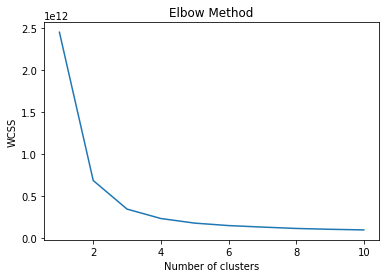

In [191]:
# Evaluate best number of clusters
def evalBestNClusters(D):
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(D)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
evalBestNClusters(X_transformed)

In [205]:
def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

def clusterintoDirectories(labels):
    directory = trainData
    sub_directories = [str(cluster) for cluster in set(labels)]

    for filename in os.listdir(directory):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(directory + '/{}'.format(cluster) , exist_ok=True)

    for i in range(len(image_names)):
        # if there isnt already a symlink of this image in the coressponding subdirectory
        if image_names[i] not in os.listdir(directory + '/' + sub_directories[labels[i]]): 
            symlink_rel(directory + '/{}'.format(image_names[i]) , 
                       directory + '/{}'.format(labels[i]) + '/' + image_names[i])

# clusterintoDirectories(HC.labels_)
clusterintoDirectories(Labels[1])
# clusterintoDirectories(gmmlabels_)

1
[[array([[[240, 185, 227],
        [221, 169, 217],
        [203, 159, 210],
        ...,
        [223, 200, 228],
        [210, 179, 210],
        [218, 183, 215]],

       [[197, 159, 196],
        [229, 194, 234],
        [210, 178, 225],
        ...,
        [228, 199, 230],
        [223, 188, 221],
        [228, 188, 222]],

       [[190, 175, 206],
        [127, 113, 148],
        [ 70,  57, 100],
        ...,
        [230, 190, 227],
        [209, 164, 203],
        [187, 141, 180]],

       ...,

       [[202, 143, 197],
        [191, 130, 187],
        [187, 123, 183],
        ...,
        [252, 177, 242],
        [245, 173, 236],
        [241, 169, 232]],

       [[142,  82, 152],
        [148,  88, 158],
        [159,  97, 170],
        ...,
        [245, 167, 229],
        [196, 121, 180],
        [167,  92, 149]],

       [[137,  80, 161],
        [125,  68, 149],
        [119,  60, 142],
        ...,
        [175,  94, 153],
        [141,  62, 119],
        [143,  66, 1

4
[[array([[[240, 185, 227],
        [221, 169, 217],
        [203, 159, 210],
        ...,
        [223, 200, 228],
        [210, 179, 210],
        [218, 183, 215]],

       [[197, 159, 196],
        [229, 194, 234],
        [210, 178, 225],
        ...,
        [228, 199, 230],
        [223, 188, 221],
        [228, 188, 222]],

       [[190, 175, 206],
        [127, 113, 148],
        [ 70,  57, 100],
        ...,
        [230, 190, 227],
        [209, 164, 203],
        [187, 141, 180]],

       ...,

       [[202, 143, 197],
        [191, 130, 187],
        [187, 123, 183],
        ...,
        [252, 177, 242],
        [245, 173, 236],
        [241, 169, 232]],

       [[142,  82, 152],
        [148,  88, 158],
        [159,  97, 170],
        ...,
        [245, 167, 229],
        [196, 121, 180],
        [167,  92, 149]],

       [[137,  80, 161],
        [125,  68, 149],
        [119,  60, 142],
        ...,
        [175,  94, 153],
        [141,  62, 119],
        [143,  66, 1

7
[[array([[[240, 185, 227],
        [221, 169, 217],
        [203, 159, 210],
        ...,
        [223, 200, 228],
        [210, 179, 210],
        [218, 183, 215]],

       [[197, 159, 196],
        [229, 194, 234],
        [210, 178, 225],
        ...,
        [228, 199, 230],
        [223, 188, 221],
        [228, 188, 222]],

       [[190, 175, 206],
        [127, 113, 148],
        [ 70,  57, 100],
        ...,
        [230, 190, 227],
        [209, 164, 203],
        [187, 141, 180]],

       ...,

       [[202, 143, 197],
        [191, 130, 187],
        [187, 123, 183],
        ...,
        [252, 177, 242],
        [245, 173, 236],
        [241, 169, 232]],

       [[142,  82, 152],
        [148,  88, 158],
        [159,  97, 170],
        ...,
        [245, 167, 229],
        [196, 121, 180],
        [167,  92, 149]],

       [[137,  80, 161],
        [125,  68, 149],
        [119,  60, 142],
        ...,
        [175,  94, 153],
        [141,  62, 119],
        [143,  66, 1

9
[[array([[[240, 185, 227],
        [221, 169, 217],
        [203, 159, 210],
        ...,
        [223, 200, 228],
        [210, 179, 210],
        [218, 183, 215]],

       [[197, 159, 196],
        [229, 194, 234],
        [210, 178, 225],
        ...,
        [228, 199, 230],
        [223, 188, 221],
        [228, 188, 222]],

       [[190, 175, 206],
        [127, 113, 148],
        [ 70,  57, 100],
        ...,
        [230, 190, 227],
        [209, 164, 203],
        [187, 141, 180]],

       ...,

       [[202, 143, 197],
        [191, 130, 187],
        [187, 123, 183],
        ...,
        [252, 177, 242],
        [245, 173, 236],
        [241, 169, 232]],

       [[142,  82, 152],
        [148,  88, 158],
        [159,  97, 170],
        ...,
        [245, 167, 229],
        [196, 121, 180],
        [167,  92, 149]],

       [[137,  80, 161],
        [125,  68, 149],
        [119,  60, 142],
        ...,
        [175,  94, 153],
        [141,  62, 119],
        [143,  66, 1

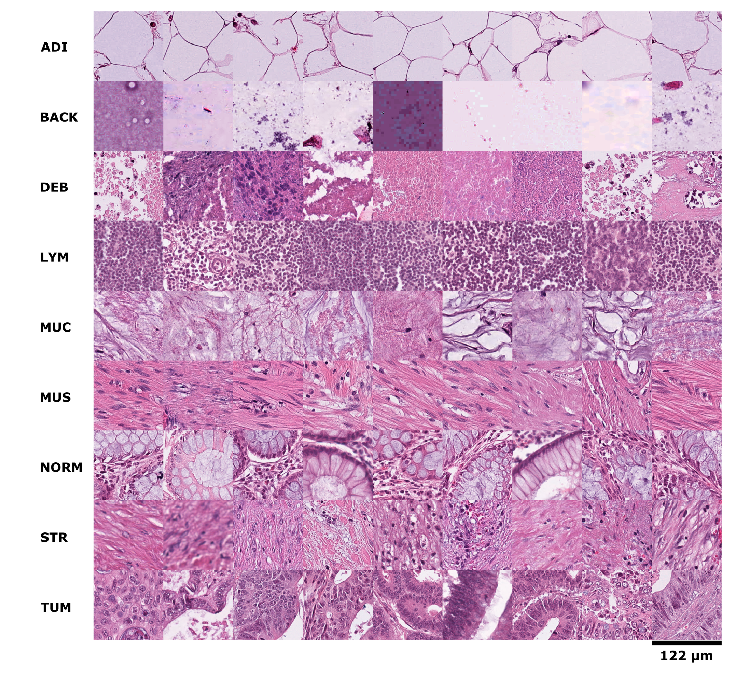

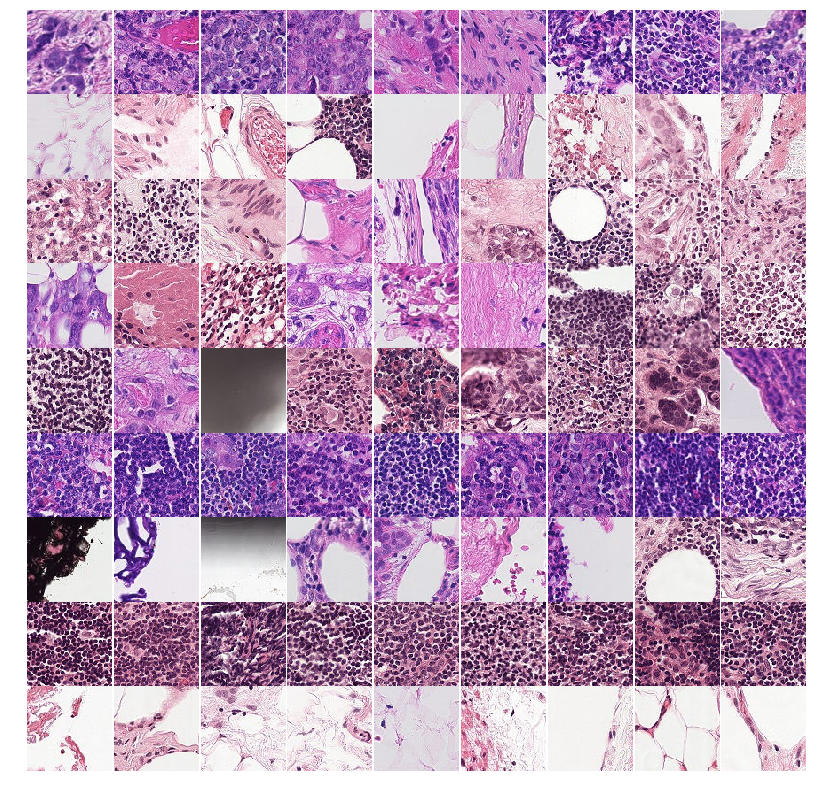

In [214]:
pltPathologyClusters(Labels[1])

(1575, 1152)
(1575, 50)
(1575, 2)


Text(0.5, 1.0, 'TSNE')

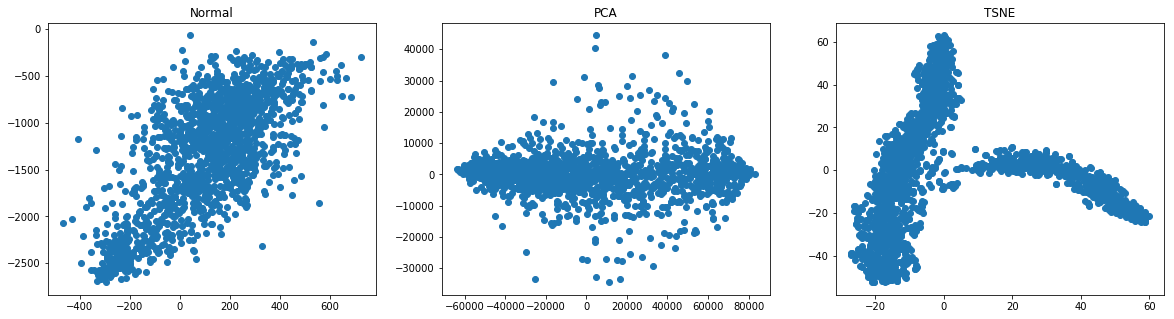

In [207]:
# reduce dimensions then cluster
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
print(X.shape)
axs[0].scatter(X[:, 0], X[:, 1], cmap='viridis');
axs[0].set_title('Normal')

# PCA 
pca = PCA(n_components=50)
X2 = pca.fit_transform(X)
print(X2.shape)

axs[1].scatter(X2[:, 0], X2[:, 1], cmap='viridis');
axs[1].set_title('PCA')

tsne = TSNE(n_components=2, perplexity=30)
X3 = tsne.fit_transform(X2)
print(X3.shape)

axs[2].scatter(X3[:, 0], X3[:, 1], cmap='viridis');
axs[2].set_title('TSNE')